In [30]:
import pandas as pd
import numpy as np
from ingest_data import IngestData

Loading the data

In [31]:
ingestdata=IngestData()
df=ingestdata.get_data('data/cancer_processed.csv')

In [32]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Columns: 1913 entries, Unnamed: 0 to state_ Wyoming
dtypes: float64(1909), int64(4)
memory usage: 44.5 MB
None
        Unnamed: 0   avgAnnCount  avgDeathsPerYear  TARGET_deathRate  \
count  3047.000000   3047.000000       3047.000000       3047.000000   
mean   1523.000000    606.338544        185.965868        178.664063   
std     879.737461   1416.356223        504.134286         27.751511   
min       0.000000      6.000000          3.000000         59.700000   
25%     761.500000     76.000000         28.000000        161.200000   
50%    1523.000000    171.000000         61.000000        178.100000   
75%    2284.500000    518.000000        149.000000        195.200000   
max    3046.000000  38150.000000      14010.000000        362.800000   

       incidenceRate      medIncome    popEst2015  povertyPercent  \
count    3047.000000    3047.000000  3.047000e+03     3047.000000   
mean      448.268586   47063

Null Values

In [33]:
null_values=df.isnull().sum()
print(null_values[null_values>0])
df.fillna(0,inplace=True)

PctSomeCol18_24            2285
PctEmployed16_Over          152
PctPrivateCoverageAlone     609
dtype: int64


Analyzing variables

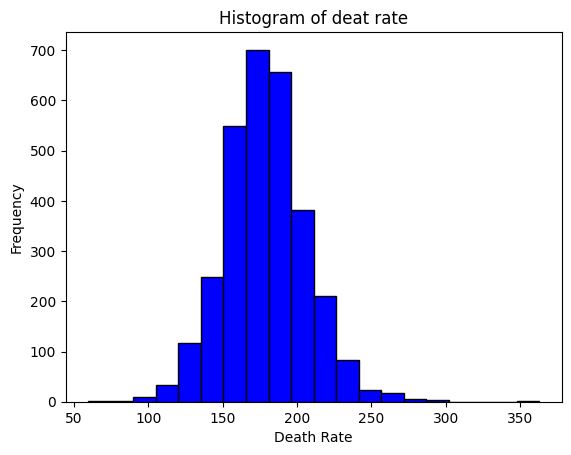

In [34]:
import matplotlib.pyplot as plt
plt.hist(df['TARGET_deathRate'],bins=20,color='blue',edgecolor='black')
plt.xlabel('Death Rate')
plt.ylabel('Frequency')
plt.title('Histogram of deat rate')
plt.show()

Observations:
Slightly positively skewed data
There are outliers as well
Mode is greater than median and mean


In [35]:
import plotly.graph_objects as gp
fig=gp.Figure(data=[gp.Box(y=df['TARGET_deathRate'],boxpoints='outliers',jitter=0.3,pointpos=-1.8)])
fig.update_layout(title='Boxplot of Death Rate',yaxis_title='Death Rate',width=700,height=500)
# fig.show()

In [36]:
#Analyzing avgAnnCount column
avg_ann_count_mean=df['avgAnnCount'].mean()
avg_ann_count_std=df['avgAnnCount'].std()
print('Mean is ',avg_ann_count_mean)
print('Standard deviation is ',avg_ann_count_std)



Mean is  606.3385437820807
Standard deviation is  1416.3562232267052


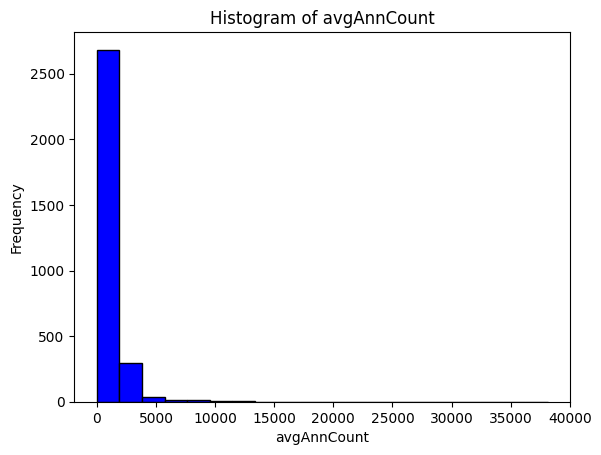

In [37]:
#Create a histogram to analyze the distribution 
plt.hist(df['avgAnnCount'],bins=20,color='blue',edgecolor='black')
plt.xlabel('avgAnnCount')
plt.ylabel("Frequency")
plt.title("Histogram of avgAnnCount")
plt.show()

In [38]:
fig=gp.Figure(data=[gp.Box(y=df['avgAnnCount'],boxpoints='outliers',jitter=0.3,pointpos=-1.8)])
fig.update_layout(title='Box plot of avganncount',yaxis_title='avgAnnCount',width=700,height=500)

In [39]:
#Calculate the correlation between avgAnnCount and target death rate
corr = df["avgAnnCount"].corr(df["TARGET_deathRate"])
print("Correlation between avgAnnCount and TARGET_deathRate: ", corr)

Correlation between avgAnnCount and TARGET_deathRate:  -0.14353161968868802


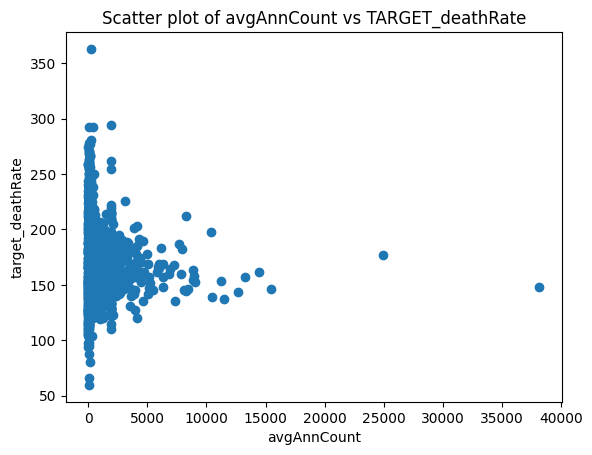

In [40]:
#Create a scatter plot betwenn avg annual count and target death rate
plt.scatter(df["avgAnnCount"],df["TARGET_deathRate"])
plt.xlabel('avgAnnCount')
plt.ylabel('target_deathRate')
plt.title('Scatter plot of avgAnnCount vs TARGET_deathRate')
plt.show()

In [41]:
print(df.shape)

(3047, 1913)


In [42]:
from scipy.stats import normaltest

In [43]:
numerical_columns=df.select_dtypes(include=np.number).columns
gaussian_cols=[]
non_gaussian_cols=[]
for col in numerical_columns:
    stat,p=normaltest(df[col])
    alpha=0.05
    if p > alpha:
        gaussian_cols.append(col)
    else:
        non_gaussian_cols.append(col)
print(gaussian_cols)


['PctPublicCoverage']


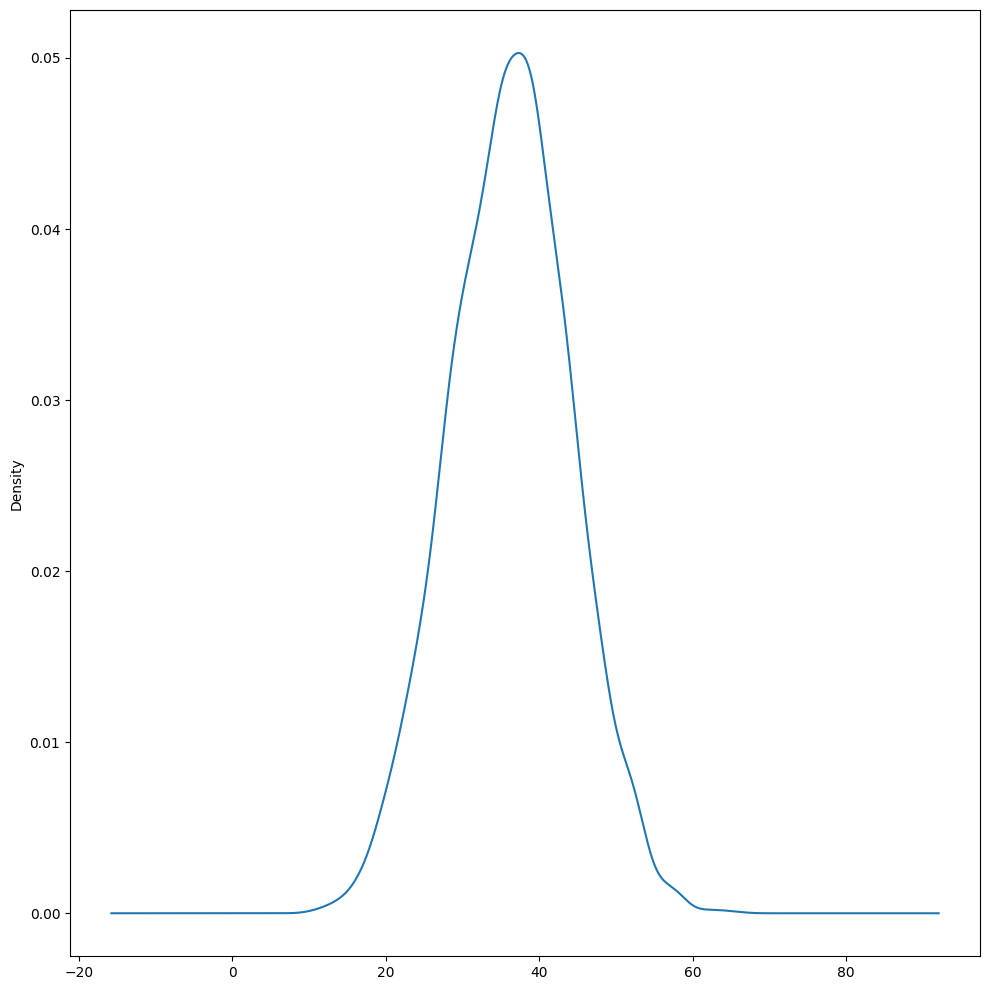

In [44]:
# make subplots for all gaussian cols as density plots to visualize gaussian columns
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(10,10))
for i,col in enumerate(gaussian_cols):
    df[col].plot(kind='density',ax=axes,subplots=True,sharex=False)
plt.tight_layout()
plt.show()

In [45]:
gaussian_data=df[gaussian_cols]
basic_info_gaussian=gaussian_data.describe()
basic_info_gaussian=basic_info_gaussian.loc[['mean','std','min','max']]
basic_info_gaussian

,PctPublicCoverage
mean,36.252642
std,7.841741
min,11.200000
max,65.100000


In [46]:
#Highest allowed and lowest allowed values
highest_allowed=basic_info_gaussian['PctPublicCoverage']['mean']+3*basic_info_gaussian['PctPublicCoverage']['std']
lowest_allowed=basic_info_gaussian["PctPublicCoverage"]["mean"] - 3*basic_info_gaussian['PctPublicCoverage']["std"]


In [47]:
def deal_with_outliers(df,col,basic_info_gaussian):
    highest_allowed=basic_info_gaussian['PctPublicCoverage']['mean']+3*basic_info_gaussian['PctPublicCoverage']['std']
    lowest_allowed=basic_info_gaussian["PctPublicCoverage"]["mean"] - 3*basic_info_gaussian['PctPublicCoverage']["std"]
    df=df[(df[col]>highest_allowed) | (df[col]<lowest_allowed)]
    return df
cols_have_outliers=[]
for col in gaussian_cols:
    data=deal_with_outliers(gaussian_data,col,basic_info_gaussian)
    shape=data.shape
    if shape[0] > 0:
        cols_have_outliers.append(col)
print(cols_have_outliers)

['PctPublicCoverage']


In [48]:
#To identify skewness remove columns which are categorical and have less than 10  unique values
cols_to_remove=[]
for col in df.columns:
    if df[col].nunique()<10:
        cols_to_remove.append(col)
print(len(cols_to_remove))
data_for_skewness=df.drop(cols_to_remove,axis=1)#It doesn't have columns whose unique values are less than 10


1880


In [49]:
def identify_skewed_cols(df,cols):
    skewed_cols=[]
    for col in cols:
        skew=df[col].skew()
        if skew>1 or skew<-1:
            skewed_cols.append(col)
    return skewed_cols
skewed_cols=identify_skewed_cols(data_for_skewness,data_for_skewness.columns)
print(len(skewed_cols))

16


In [50]:
skewed_data=data_for_skewness[skewed_cols]

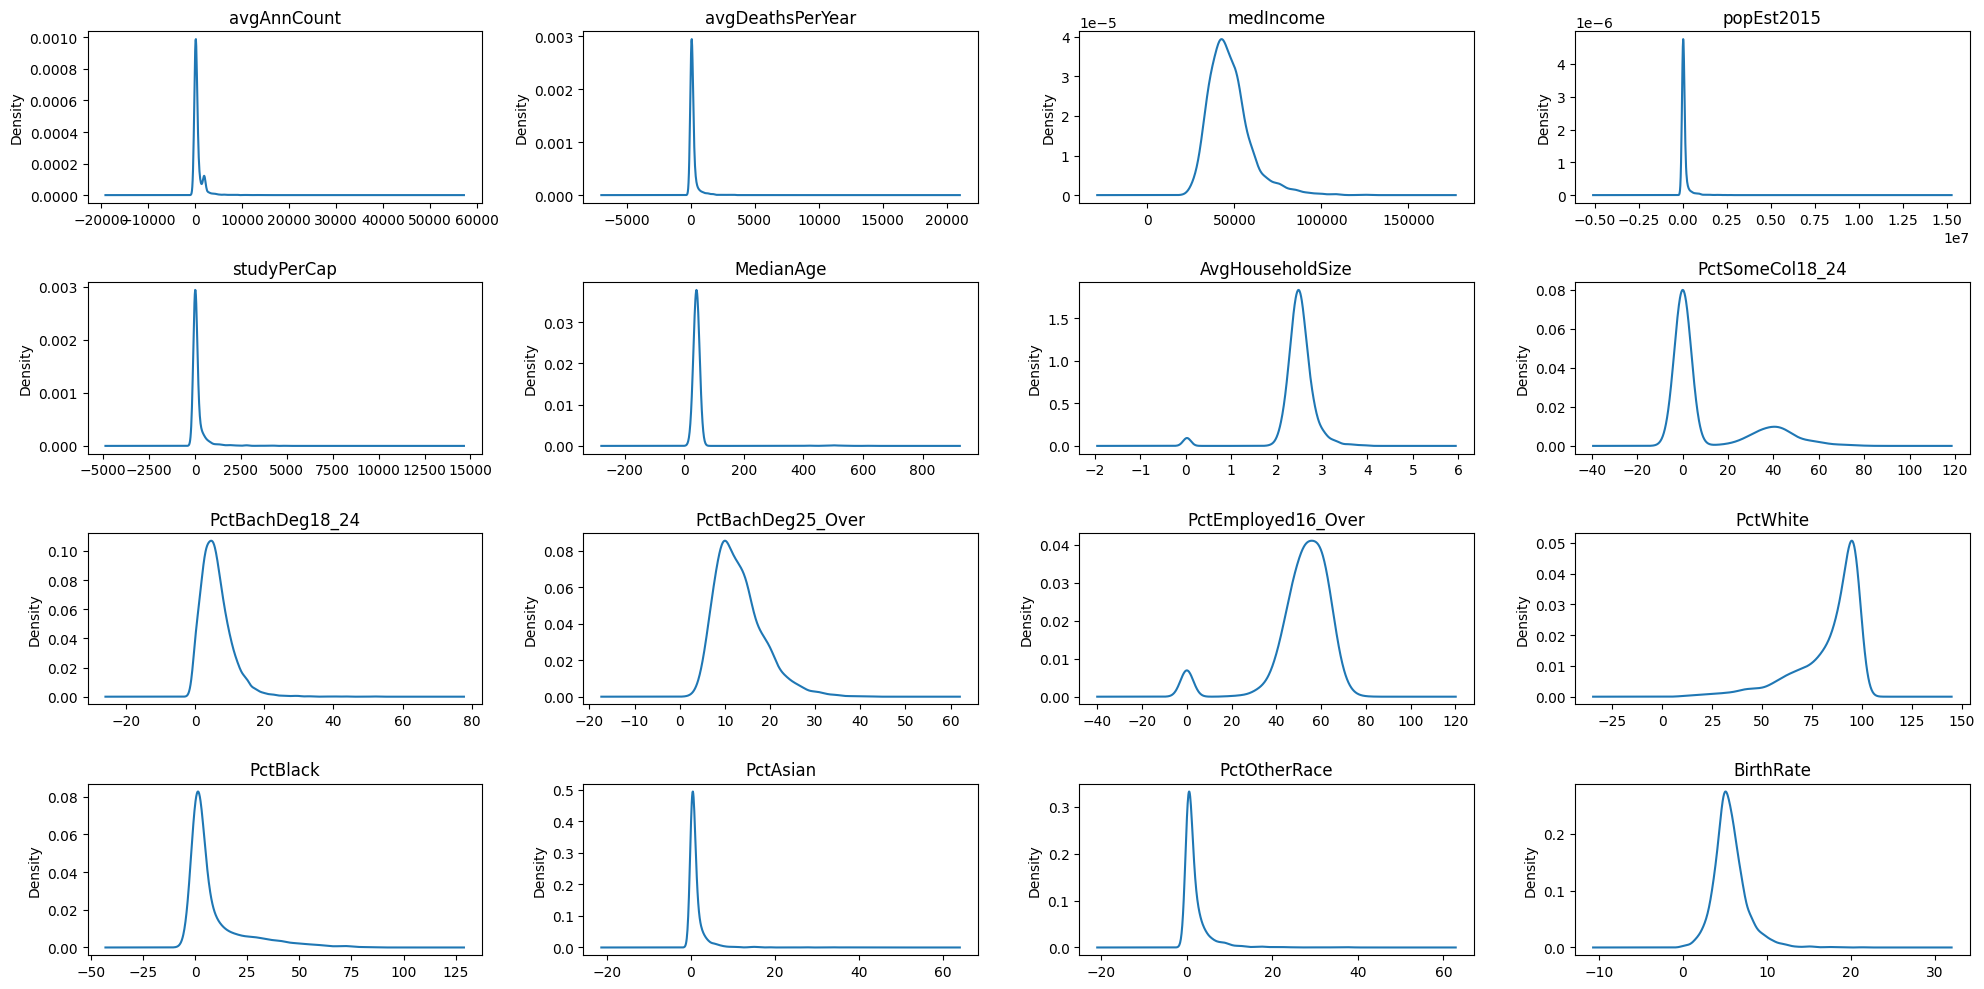

In [51]:
fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(20,10))
for i,col in enumerate(skewed_cols):
    axes[i//4,i%4].set_title(col)
    skewed_data[col].plot(kind='density',ax=axes[i//4,i%4],subplots=True,sharex=False)
plt.tight_layout()
plt.show()

In [52]:
def box_plot(df, col):
    fig = gp.Figure(data=[gp.Box(y=df[col], boxpoints='outliers', jitter=0.3, pointpos=-1.8)])
    fig.update_layout(
        title='Boxplot of ' + col,
        yaxis_title=col,
        width=500,
        height=500)
    fig.show()

for col in skewed_cols:
    box_plot(df, col)


In [53]:
# checking outlier values for studypercap column
percentile25 = df['studyPerCap'].quantile(0.25)
percentile75 = df['studyPerCap'].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Upper limit",upper_limit)
print("Lower limit",lower_limit)

Upper limit 209.1269406875
Lower limit -125.4761644125


In [54]:
def deal_with_outlier_with_iqr(df, col):
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    outliers = df[(df[col] > upper_limit) | (df[col] < lower_limit)]
    return outliers
cols_have_outliers_skewed = []
for col in skewed_cols:
    outliers = deal_with_outlier_with_iqr(df, col)
    shape = outliers.shape
    if shape[0] > 0:
        cols_have_outliers_skewed.append(col)
print(cols_have_outliers_skewed)    

['avgAnnCount', 'avgDeathsPerYear', 'medIncome', 'popEst2015', 'studyPerCap', 'MedianAge', 'AvgHouseholdSize', 'PctSomeCol18_24', 'PctBachDeg18_24', 'PctBachDeg25_Over', 'PctEmployed16_Over', 'PctWhite', 'PctBlack', 'PctAsian', 'PctOtherRace', 'BirthRate']


In [55]:
# capping 
for col in cols_have_outliers:
    highest_allowed = basic_info_gaussian[col]["mean"] + 3*basic_info_gaussian[col]["std"] 
    lowest_allowed = basic_info_gaussian[col]["mean"] - 3*basic_info_gaussian[col]["std"]
    capped_data = df.copy()
    capped_data.loc[capped_data[col] > highest_allowed, col] = highest_allowed
    capped_data.loc[capped_data[col] < lowest_allowed, col] = lowest_allowed
capped_data

,Unnamed: 0,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,...,state_ South Dakota,state_ Tennessee,state_ Texas,state_ Utah,state_ Vermont,state_ Virginia,state_ Washington,state_ West Virginia,state_ Wisconsin,state_ Wyoming
0,0,1397.000000,469,164.9,489.800000,61898,260131,11.2,499.748204,39.3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,102.000000,50,174.7,349.700000,49348,21026,14.6,47.560164,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,42.8,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,48.3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,3042,1962.667684,15,149.6,453.549422,46961,6343,12.4,0.000000,44.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3043,3043,1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,30.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3044,3044,1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,30.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3045,3045,1962.667684,52,175.0,453.549422,50745,25609,13.3,0.000000,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
def capping(df, col):
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    df.loc[df[col] > upper_limit, col] = upper_limit
    df.loc[df[col] < lower_limit, col] = lower_limit
    return df 

for col in cols_have_outliers_skewed:
    capped_data = capping(df, col)
capped_data.shape

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8224\3015515723.py:7: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '330.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8224\3015515723.py:7: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '72906.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8224\3015515723.py:7: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '154151.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



(3047, 1913)

In [57]:
for col in cols_have_outliers_skewed:
    box_plot(capped_data,col)

In [58]:
capped_data.to_csv('capped_data.csv', index=False)